identify domains in 3-component system using Voronoi edge method to determine neighbors and Lo/Ld

then, find domain interface length from Voronoi edges

based off of registration fraction code

mdw 02/03/2017


In [634]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [635]:
traj=md.load('one_18,5ns.xtc',top='one_18,5ns.gro',stride=100)

In [636]:
traj.n_frames

6

In [637]:
topology=traj.topology
allhead=topology.select('name P8 or name OA')
dbpc_tail = topology.select('name C33 and resname DBPC or name C34 and resname DBPC or name C35 and resname DBPC or name C56 and resname DBPC or name C57 and resname DBPC or name C58 and resname DBPC')
dbpc_head = topology.select('name P8 and resname DBPC or name C6 and resname DBPC')

dipc_tail = topology.select('name C31 and resname DIPC or name C51 and resname DIPC or name C52 and resname DIPC or name C50 and resname DIPC  or name C53 and resname DIPC or name C54 and resname DIPC ')
dipc_head = topology.select('name P8 and resname DIPC or name C6 and resname DIPC')

pipc_tail = topology.select('name C31 and resname DNPC or name C51 and resname DNPC or name C52 and resname DNPC or name C48 and resname DNPC or name C49 and resname DNPC or name C50 and resname DNPC')
pipc_head = topology.select('name P8 and resname DNPC or name C6 and resname DNPC')

In [638]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications
allheadxy=list([] for _ in xrange(traj.n_frames))
allheadz=list([] for _ in xrange(traj.n_frames))
allheadxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])
        allheadxyz[nn].append(traj.xyz[nn][allheadi][0:3:1])


In [639]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
dbpc_tailxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(dbpc_tail)):
        dbpc_taili=dbpc_tail[i]
        dbpc_tailxyz[nn].append(traj.xyz[nn][dbpc_taili][0:3:1])
        
dbpc_headxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(dbpc_head)):
        dbpc_headi=dbpc_head[i]
        dbpc_headxyz[nn].append(traj.xyz[nn][dbpc_headi][0:3:1])

In [640]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
dipc_tailxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(dipc_tail)):
        dipc_taili=dipc_tail[i]
        dipc_tailxyz[nn].append(traj.xyz[nn][dipc_taili][0:3:1])
        
dipc_headxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(dipc_head)):
        dipc_headi=dipc_head[i]
        dipc_headxyz[nn].append(traj.xyz[nn][dipc_headi][0:3:1])

In [641]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value

pipc_tailxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(pipc_tail)):
        pipc_taili=pipc_tail[i]
        pipc_tailxyz[nn].append(traj.xyz[nn][pipc_taili][0:3:1])
        
pipc_headxyz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(pipc_head)):
        pipc_headi=pipc_head[i]
        pipc_headxyz[nn].append(traj.xyz[nn][pipc_headi][0:3:1])

In [642]:
resnames=[atom.residue.name for atom in topology.atoms]

In [643]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=list([] for _ in xrange(traj.n_frames))
allheadz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])


In [644]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
#cutoffsq = 2.4**2; #square of maximum xy distance for neighbors
cutoffsq=1.0**2
neigh=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    neigh[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allheadxy[nn])):
        xyi=allheadxy[nn][i]
        for j in range(len(allhead)-i-1): #not self, but will add for midplane finding
            xyj=allheadxy[nn][j+i+1]
            distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
            if (distsq < cutoffsq):
                neigh[nn][i].append(j+i+1)
                neigh[nn][j+i+1].append(i)
  

In [645]:
#new leaflet id method based on tilt angles; PO4-C4A or ROH-C1 (both +6 beads)
num_head=len(allhead)
tiltvectors=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    tiltvectors[nn]=list([] for _ in xrange(num_head)) #store vector roh-c1 or po4-c4a
    
    for i in range(num_head):
        tiltvectors[nn][i]=traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[i]+6]


In [646]:
# must fix periodic boundary condition errors in tiltvectors, then calculate tiltangle
norms=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    norms[nn]=list([] for _ in xrange(len(allhead)))
    halfx=0.5*traj.unitcell_lengths[nn][0]
    halfy=0.5*traj.unitcell_lengths[nn][1]
    halfz=0.5*traj.unitcell_lengths[nn][2]
    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])
        if (norms[nn][i] > halfz):
            if (np.abs(tiltvectors[nn][i][0]) > halfx):
                if (tiltvectors[nn][i][0]>0): 
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]-2*halfx
                else:
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]+2*halfx
            if (np.abs(tiltvectors[nn][i][1]) > halfy):
                if (tiltvectors[nn][i][1]>0): 
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]-2*halfy
                else:
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]+2*halfy
            if (np.abs(tiltvectors[nn][i][2]) > halfz):
                if (tiltvectors[nn][i][2]>0): 
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]-2*halfz
                else:
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]+2*halfz

    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])


In [647]:
# use neigh to find local average tilt vector, outliers are not in a leaflet
# if pointing neg in z, flip in x,y,z for making average in outer leaflet
localvector=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    localvector[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        localvectorsx=[]
        localvectorsy=[]
        localvectorsz=[]
        sgn=np.sign(tiltvectors[nn][i][2])
        localvectorsx.append(sgn*tiltvectors[nn][i][0]) #include self
        localvectorsy.append(sgn*tiltvectors[nn][i][1]) #include self
        localvectorsz.append(sgn*tiltvectors[nn][i][2]) #include self
        for j in range(len(neigh[nn][i])):
            sgn=np.sign(tiltvectors[nn][neigh[nn][i][j]][2])
            localvectorsx.append(sgn*tiltvectors[nn][neigh[nn][i][j]][0])
            localvectorsy.append(sgn*tiltvectors[nn][neigh[nn][i][j]][1])
            localvectorsz.append(sgn*tiltvectors[nn][neigh[nn][i][j]][2])
        localvector[nn][i]=[np.mean(localvectorsx),np.mean(localvectorsy),np.mean(localvectorsz)]
       

In [648]:
# find angle between orientation vector and local average orientation vector for each lipid
# in range [0,180]
diffangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    diffangle[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        normlv=np.linalg.norm(localvector[nn][i])
        normtv=np.linalg.norm(tiltvectors[nn][i])
        cos=np.dot(localvector[nn][i],tiltvectors[nn][i])/(normlv*normtv)
        if (cos==0):
            diffangle[nn][i]=90
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=0
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=180
        else:
            diffangle[nn][i]=np.arccos(cos)*180./np.pi


In [649]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        if (diffangle[nn][i]>120):
            head_leaflet[nn][i]=0
        elif (diffangle[nn][i]<60):
            head_leaflet[nn][i]=1
        else:
            head_leaflet[nn][i]=2

In [650]:
# want to identify all midplane chol and remove all "midplane" phospholipids
# tilt angle insufficient
# chol: find distance from ROH to nearest PO4; if beyond threshold, then in midplane; 
# else, copy leaflet ID (do for all phospholipids); only if copying non-midplane

for nn in range(traj.n_frames):
    fixedchol=0
    fixedphos=0
    midplanechol=0
    for i in range(len(allhead)):
        mindist=100.0
        if (head_leaflet[nn][i]==2 and (not resnames[allhead[i]]=='CHOL')): #phospholipids, must assign
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            head_leaflet[nn][i]=correct_leaflet
            fixedphos=fixedphos+1
    #must fix all phospholipids before all chols, since some may use fixed phospholipid leaflet id
    # so, must go through allhead twice
    for i in range(len(allhead)):
        mindist=100.0
        if (resnames[allhead[i]]=='CHOL'): #all chol, ignoring angle
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist<1.4): #close to a headgroup, so in a leaflet
                head_leaflet[nn][i]=correct_leaflet
                fixedchol=fixedchol+1
            else:
                head_leaflet[nn][i]=2
                midplanechol=midplanechol+1

In [651]:
# only need upper leaflet heads for this situation
upperheads=list([] for _ in xrange(traj.n_frames))
lowerheads=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    upperheads[nn]=[]
    for i in range(len(allhead)):
        if head_leaflet[nn][i]==1:
            upperheads[nn].append(allhead[i])
        if head_leaflet[nn][i]==0:
            lowerheads[nn].append(allhead[i])

In [653]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
globalconc=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    upperdppc[nn]=0
    for j in range(len(upperheads[nn])):
        if(resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            upperdppc[nn]=upperdppc[nn]+1
    globalconc[nn]=float(upperdppc[nn])/len(upperheads[nn])

In [654]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
reg=list([] for _ in xrange(traj.n_frames))
frac_reg=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0
            
            
# calculate opposite phase
    oppneigh=list([] for _ in xrange(len(upperheads[nn]))) #for upper, lower neighbors (xy dist)
    for i in range(len(upperheads[nn])):
        for j in range(len(neigh[nn][i])):
            if (head_leaflet[nn][neigh[nn][i][j]]==0): # if lower
                oppneigh[i].append(resnames[allhead[neigh[nn][i][j]]])
#           oppneighres[i].append(allhead[neigh[i][j]])

    oppphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        oppneightot=len(oppneigh[i])
        num_sat=0
        for j in range(len(oppneigh[i])):
            if (oppneigh[i][j]=='DXPC' or oppneigh[i][j]=='DBPC' or oppneigh[i][j]=='DPPC' or oppneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        if (oppneightot):
            local_conc=float(num_sat)/oppneightot
        else:
            local_conc=0
        if (local_conc > globalconc[nn]):
            oppphase[i] = 1 #Lo
        else:
            oppphase[i] = 0 #Ld
    

# for more logical comparison, iterate twice, using upper Voronoi neighbors' oppphase values
    oppphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase2[i]=1
        else: 
            oppphase2[i]=0

    oppphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase2[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase3[i]=1
        else: 
            oppphase3[i]=0
        
        
# compare oppphase3 to vphase3 to check for registration
    reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        if (oppphase3[i]==vphase3[i]):
            reg[nn][i]=1 # registered
        else:
            reg[nn][i]=0 # not registered
    frac_reg[nn]=float(sum(reg[nn]))/len(reg[nn])

In [712]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
intmember=list([] for _ in xrange(traj.n_frames))
intfrac=list([] for _ in xrange(traj.n_frames))
regintfrac=list([] for _ in xrange(traj.n_frames))
u_phase_global = list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
#    headxy[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
        

    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])



    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])


#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[i]=1
        else:
            vphase3[i]=0
            
#################################################################################
#ONLY GOING TO USE VPHASE TO CREAT U_PHASE
    domain=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])): #N: Cycling through all molecule heads
        domain[i]=0 # 0 = unassigned; N: Assigning each domain a value of 0

    recurlist=[] # list of heads that must run through domain algorithm because in chain of neighbors

    domain[0]=1 # first lipid sets first domain
    for i in range(len(vneighres[0])): # vneighres is allheadz index, not atom
        ni=vneighres[0][i] #N: Looking at specific patch
        if vphase[ni]==vphase[0]: #only neighbors in same phase; N: Check if they have the same phase
            domain[ni]=1
            recurlist.append(ni) #N: Add it the heads that need to be checked against their neighbors
    num_domains=1
    
    while len(recurlist): # no new domain should be introduced in this section
        headi=recurlist[0] #N: Looking at the first entry in recurlist
        neighi=vneighres[headi] #N: Finding its neighbors
        recurlist=recurlist[1:] # remove 1st element, now being handled
        for j in range(len(neighi)):#N: For all of its neighbors
            ni=neighi[j] 
            if (vphase[ni]==vphase[headi] and domain[ni]==0): #avoid infinitely putting back into recurlist; N: is the phase same as domian
                domain[ni]=domain[headi] #N: Domain is the same as the head
                recurlist.append(ni) #N: Put it back in the list to be checked again

    #now iterate over other lipids, excluding those already marked
    for i in range(len(upperheads[nn])-1): # 0 already done
        if domain[i+1]==0: #not yet marked
            neighi=vneighres[i+1]
            num_domains=num_domains+1
            domain[i+1]=num_domains
            for j in range(len(neighi)):
                ni=neighi[j]
                if vphase[ni]==vphase[i+1]:
                    domain[ni]=domain[i+1] 
                    recurlist.append(ni)
            while len(recurlist): #until exhausted, then move onto next new domain
                headi=recurlist[0]
                neighi=vneighres[headi]
                recurlist=recurlist[1:]
                for j in range(len(neighi)):
                    ni=neighi[j]
                    if (vphase[ni]==vphase[headi] and domain[ni]==0):
                        domain[ni]=domain[headi]
                        recurlist.append(ni)
                        
    # see how many lipids in each domain
    num_domains=max(domain)
    domainsize=list([] for _ in xrange(num_domains))
    for i in range(len(domainsize)):
        domainsize[i]=0
    for i in range(len(domain)):
        di=domain[i]-1 #return to 0-index
        domainsize[di]=domainsize[di]+1

    #N: Method to get rid of domains that are less than 10 lipids long. 1) Find domains which are less than 10 lipids 
    #N: 2) Take every lipid with a small domain and add it to a list 3) Take that list and change the phase, and make
    #N: an  updated phase list

    #N: Going to make a list of the domains which are too small
    small_domain=[]
    lipid_counter=0 #N: Total number of lipids 
    for i in range(len(domainsize)): 
        if domainsize[i]<10: 
            small_domain.append(i+1)
            lipid_counter=lipid_counter+domainsize[i]


    #N: Go through domain(holds which domain every lipid belongs to) and see if its domain is in small_domian
    #N: If it is, its phase needs to be changed 
    phase_req_change=[]
    for i in range(len(domain)):
        if domain[i] in small_domain:
            phase_req_change.append(i)

    #N: Go through phase_req_change. Each entry is the lipid whose phase needs to be switched. So take that entry
    #N: and plug it into u_phase. Then switch the value of u_phase.
    u_phase=[]
    for i in range(len(vphase)):
        if i in phase_req_change:
            #print(n)
            if vphase[i]==0:
                u_phase.append(1)
            if vphase[i]==1:
                u_phase.append(0)
        else: 
            u_phase.append(vphase[i])
    u_phase_global[nn]=u_phase
#############################################################

# find Voronoi edges that are domain edges as well
# find lipids that are "members" of the interface, i.e. have at least one edge on it
    regint=0
    intmember[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (u_phase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(u_phase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            intmember[nn][i]=0
        else: #not all neighbors belong to same phase
            intmember[nn][i]=1
            if (reg[nn][i]==1): #looking to see if int lipids are more often antiregistered
                regint=regint+1

    intfrac[nn]=float(sum(intmember[nn]))/len(intmember[nn])
    regintfrac[nn]=float(regint)/sum(intmember[nn]) #fraction of int lipids R, compare to overall
            
 

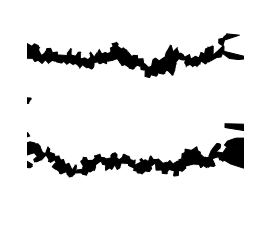

In [656]:
#plot reg vs antireg
# color Voronoi polygons
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('gray_r')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in intmember[-1]])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig('intf'+name+'.pdf',format='pdf')
plt.show()

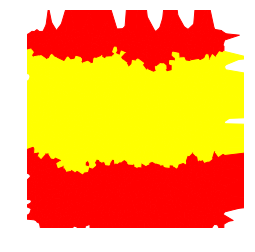

In [657]:
# color Voronoi polygons
#N: Make an updated picture of new phases
fig,ax=plt.subplots(1)
patches=[]
cmap=plt.get_cmap('autumn')
#flatphase=[val for sublist in cphase for val in sublist]
#colors=cmap([x*10 for x in flatphase])
colors=cmap([(x*256) for x in u_phase])
#for region in range(len(vor.regions)):
#    if not -1 in vor.regions[region]:
#        pg=Polygon(vor.vertices,closed=True)
#        patches.append(pg)




for i in range(len(vor.point_region)):
    verts=vor.regions[vor.point_region[i]] #indices of vertices forming that region
    if (verts==[]):
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    elif (not -1 in verts):
        vertcoord=list([] for _ in xrange(len(verts))) #coordinates of vertices
        for j in range(len(verts)):
            k=verts[j]
            vertcoord[j]=vor.vertices[k]
        pg=Polygon(vertcoord,closed=True)
        patches.append(pg)
    else:
        pg=Polygon(np.array([[-1,-1],[-1.1,-1.1]]),closed=True)
        patches.append(pg)
    



collection=PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
        
#plt.fill(*zip(*pg))
ax.set_aspect('equal')
ax.set_xlim([0,36.5])
ax.set_ylim([0,36.5])

plt.axis('off')

#plt.savefig(name+'.pdf',format='pdf')
plt.show()

In [658]:
len(intmember)

6

In [659]:
#Find All lipids on the interface and place into an array
lo_edge = list([] for _ in xrange(traj.n_frames))
ld_edge = list([] for _ in xrange(traj.n_frames))
edge=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):

    for i in range(len(intmember[nn])) : 
        if intmember[nn][i]==1 and u_phase[i]==0: 
            ld_edge[nn].append(i)
        if intmember[nn][i]==1 and u_phase[i]==1: 
            lo_edge[nn].append(i)
            
for nn in range(traj.n_frames):
    for i in range(len(lo_edge[nn])):
        edge[nn].append(allheadxy[nn][lo_edge[nn][i]])
    for i in range(len(ld_edge[nn])):
        edge[nn].append(allheadxy[nn][ld_edge[nn][i]])

In [660]:
len(ld_edge[0])

126

In [661]:
#1) Find Center of Mass of last 3 carbons for every lipid
#2) Find Center of Mass for head of each lipid 
#3) Find closest distance to interface 
#4) Define angles to head and to interface 

In [662]:
def center_of_mass6(coord1,coord2,coord3,coord4,coord5,coord6,mass1,mass2): 
    com=(coord1*mass1 + coord2*mass1 + coord3*mass2 +coord4*mass1 + coord5*mass1 + coord6*mass2)
    com=com/(mass1*4 + mass2*2)
    return com

In [663]:
def center_of_mass2(coord1,coord2,mass1,mass2): 
    com=(coord1*mass1 + coord2*mass2)
    com=com/(mass1 + mass2)
    return com

In [664]:
def local_vector(cord1,cord2):
    vector = [cord1[0]-cord2[0],cord1[1]-cord2[1],cord1[2]-cord2[2]]
    d=(cord1[0]-cord2[0])**2 + (cord1[1]-cord2[1])**2 + (cord1[2]-cord2[2])**2
    vector=vector/(d**.5)
    return vector
    

In [665]:
def distance(cord1,cord2):
    d=(cord1[0]-cord2[0])**2 + (cord1[1]-cord2[1])**2 + (cord1[2]-cord2[2])**2
    d=d**.5
    return d

In [666]:
def distance_2d(cord1,cord2):
    d=(cord1[0]-cord2[0])**2 + (cord1[1]-cord2[1])**2 
    d=d**.5
    return d

In [667]:
def magvect(v):
    magnitude = np.sqrt(v[0]*v[0] + v[1]*v[1] + v[2]*v[2])
    return magnitude

In [668]:
def angle(v1,v2):
    ang = np.arccos(np.dot(v1,v2)/(magvect(v1)*magvect(v2)))
    ang = ang*180/np.pi
    return ang

In [777]:
upper_dbpc_tail_com = list([] for _ in xrange(traj.n_frames))
upper_dbpc_head_com = list([] for _ in xrange(traj.n_frames))
upper_dbpc_phase=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames): 
    for i in range(len(dbpc_head)):
        if dbpc_head[i] in upperheads[nn] and resnames[dbpc_head[i]]=='DBPC': 
            p8=np.array(dbpc_headxyz[nn][i])
            c6=np.array(dbpc_headxyz[nn][i-1])
            xcom=center_of_mass2(p8[0],c6[0],14.0270,30.9738)
            ycom=center_of_mass2(p8[1],c6[1],14.0270,30.9738)
            zcom=center_of_mass2(p8[2],c6[2],14.0270,30.9738)
            upper_dbpc_head_com[nn].append([xcom,ycom,zcom])

            
for nn in range(traj.n_frames):
    for i in range(len(dbpc_tail)): 
        if (int(dbpc_tail[i]) - 25) in upperheads[nn] and resnames[dbpc_tail[i]-25]=="DBPC":
            c33=np.array(dbpc_tailxyz[nn][i])
            c34=np.array(dbpc_tailxyz[nn][i+1])
            c35=np.array(dbpc_tailxyz[nn][i+2])
            c56=np.array(dbpc_tailxyz[nn][i+3])
            c57=np.array(dbpc_tailxyz[nn][i+4])
            c58=np.array(dbpc_tailxyz[nn][i+5])
            xcom= center_of_mass6(c33[0],c34[0],c35[0],c56[0],c57[0],c58[0],14.0270,15.0350)
            ycom= center_of_mass6(c33[1],c34[1],c35[1],c56[1],c57[1],c58[1],14.0270,15.0350)
            zcom= center_of_mass6(c33[2],c34[2],c35[2],c56[2],c57[2],c58[2],14.0270,15.0350)
            upper_dbpc_tail_com[nn].append([xcom,ycom,zcom])

upper_dbpc_distance_to_interface= list([] for _ in xrange(traj.n_frames))  
for nn in range(traj.n_frames):
    for i in range(len(upper_dbpc_head_com[nn])): 
        d=[]
        for j in range(len(edge[nn])):
            d.append(distance_2d(upper_dbpc_head_com[nn][i][0:2],edge[nn][j]))
        upper_dbpc_distance_to_interface[nn].append(np.min(d))

upper_dbpc_tiltangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upper_dbpc_head_com[nn])): 
        v = local_vector(upper_dbpc_head_com[nn][i],upper_dbpc_tail_com[nn][i])
        theta=angle(v,[0,0,1])
        upper_dbpc_tiltangle[nn].append(theta)

In [778]:
dbpc_phase=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upperheads[nn])):
        if resnames[upperheads[nn][i]]=='DBPC':
            dbpc_phase[nn].append(u_phase_global[nn][i])

In [779]:
upper_dipc_tail_com = list([] for _ in xrange(traj.n_frames))
upper_dipc_head_com = list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames): 
    for i in range(len(dipc_head)):
        if dipc_head[i] in upperheads[nn] and resnames[dipc_head[i]]=='DIPC': 
            p8=np.array(dipc_headxyz[nn][i])
            c6=np.array(dipc_headxyz[nn][i-1])
            xcom=center_of_mass2(p8[0],c6[0],14.0270,30.9738)
            ycom=center_of_mass2(p8[1],c6[1],14.0270,30.9738)
            zcom=center_of_mass2(p8[2],c6[2],14.0270,30.9738)
            upper_dipc_head_com[nn].append([xcom,ycom,zcom])
            
for nn in range(traj.n_frames):
    for i in range(len(dipc_tail)): 
        if (int(dipc_tail[i]) - 23) in upperheads[nn] and resnames[dipc_tail[i]-23]=='DIPC':
            c33=np.array(dipc_tailxyz[nn][i])
            c34=np.array(dipc_tailxyz[nn][i+1])
            c35=np.array(dipc_tailxyz[nn][i+2])
            c56=np.array(dipc_tailxyz[nn][i+3])
            c57=np.array(dipc_tailxyz[nn][i+4])
            c58=np.array(dipc_tailxyz[nn][i+5])
            #print(c33,c34,c35,c56,c57,c58)
            xcom= center_of_mass6(c33[0],c34[0],c35[0],c56[0],c57[0],c58[0],14.0270,15.0350)
            ycom= center_of_mass6(c33[1],c34[1],c35[1],c56[1],c57[1],c58[1],14.0270,15.0350)
            zcom= center_of_mass6(c33[2],c34[2],c35[2],c56[2],c57[2],c58[2],14.0270,15.0350)
            upper_dipc_tail_com[nn].append([xcom,ycom,zcom])

upper_dipc_distance_to_interface= list([] for _ in xrange(traj.n_frames))  
for nn in range(traj.n_frames):
    for i in range(len(upper_dipc_head_com[nn])): 
        d=[]
        for j in range(len(edge[nn])):
                d.append(distance_2d(upper_dipc_head_com[nn][i],edge[nn][j]))
        upper_dipc_distance_to_interface[nn].append(np.min(d))

upper_dipc_tiltangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upper_dipc_head_com[nn])): 
        v = local_vector(upper_dipc_head_com[nn][i],upper_dipc_tail_com[nn][i])
        theta=angle(v,[0,0,1])
        upper_dipc_tiltangle[nn].append(theta)

In [780]:
dipc_phase=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upperheads[nn])):
        if resnames[upperheads[nn][i]]=='DIPC':
            dipc_phase[nn].append(u_phase_global[nn][i])

In [781]:
upper_pipc_tail_com = list([] for _ in xrange(traj.n_frames))
upper_pipc_head_com = list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames): 
    for i in range(len(pipc_head)):
        if pipc_head[i] in upperheads[nn] and resnames[pipc_head[i]]=='DIPC': 
            p8=np.array(pipc_headxyz[nn][i])
            c6=np.array(pipc_headxyz[nn][i-1])
            xcom=center_of_mass2(p8[0],c6[0],14.0270,30.9738)
            ycom=center_of_mass2(p8[1],c6[1],14.0270,30.9738)
            zcom=center_of_mass2(p8[2],c6[2],14.0270,30.9738)
            upper_pipc_head_com[nn].append([xcom,ycom,zcom])
            
for nn in range(traj.n_frames):
    for i in range(len(pipc_tail)): 
        if (int(pipc_tail[i]) - 23) in upperheads[nn] and resnames[pipc_tail[i]-23]=='DNPC':
            c33=np.array(pipc_tailxyz[nn][i])
            c34=np.array(pipc_tailxyz[nn][i+1])
            c35=np.array(pipc_tailxyz[nn][i+2])
            
            c56=np.array(pipc_tailxyz[nn][i+3])
            c57=np.array(pipc_tailxyz[nn][i+4])
            c58=np.array(pipc_tailxyz[nn][i+5])
            #print(c33,c34,c35,c56,c57,c58)
            xcom= center_of_mass6(c33[0],c34[0],c35[0],c56[0],c57[0],c58[0],14.0270,15.0350)
            ycom= center_of_mass6(c33[1],c34[1],c35[1],c56[1],c57[1],c58[1],14.0270,15.0350)
            zcom= center_of_mass6(c33[2],c34[2],c35[2],c56[2],c57[2],c58[2],14.0270,15.0350)
            upper_pipc_tail_com[nn].append([xcom,ycom,zcom])

upper_pipc_distance_to_interface= list([] for _ in xrange(traj.n_frames))  
for nn in range(traj.n_frames):
    for i in range(len(upper_pipc_head_com[nn])): 
        d=[]
        for j in range(len(edge[nn])):
                d.append(distance_2d(upper_pipc_head_com[nn][i],edge[nn][j]))
        upper_pipc_distance_to_interface[nn].append(np.min(d))

upper_pipc_tiltangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upper_pipc_head_com[nn])): 
        v = local_vector(upper_pipc_head_com[nn][i],upper_pipc_tail_com[nn][i])
        theta=angle(v,[0,0,1])
        upper_pipc_tiltangle[nn].append(theta)

In [782]:
pipc_phase=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(upperheads[nn])):
        if resnames[upperheads[nn][i]]=='DNPC':
            pipc_phase[nn].append(u_phase_global[nn][i])

In [887]:
dbpc_distance_bined=list([] for _ in xrange(traj.n_frames))
dipc_distance_bined=list([] for _ in xrange(traj.n_frames))
pipc_distance_binded=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    dbpc_distance_bined[nn]=np.digitize(upper_dbpc_distance_to_interface[nn],np.arange(0,10,.5))
    dipc_distance_bined[nn]=np.digitize(upper_dipc_distance_to_interface[nn],np.arange(0,10,.5))
    pipc_distance_binded[nn]=np.digitize(upper_pipc_distance_to_interface[nn],np.arange(0,10,.5))
          
LO=list([] for _ in xrange(traj.n_frames))
LD=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    LO[nn]=list([] for _ in xrange(len(np.arange(0,10,.5))))
    LD[nn]=list([] for _ in xrange(len(np.arange(0,10,.5))))
    for i in range(len(dbpc_phase[nn])):
        if str(dbpc_phase[nn][i])=="1":
            LO[nn][dbpc_distance_bined[nn][i]].append(float(upper_dbpc_tiltangle[nn][i]))
        if str(dbpc_phase[nn][i])=="0":
            LD[nn][dbpc_distance_bined[nn][i]].append(float(upper_dbpc_tiltangle[nn][i]))

for nn in range(traj.n_frames):
    for i in range(len(dipc_phase[nn])):
        if str(dipc_phase[nn][i])=="1":
            LO[nn][dipc_distance_bined[nn][i]].append(float(upper_dipc_tiltangle[nn][i]))
        if str(dipc_phase[nn][i])=="0":
            LD[nn][dipc_distance_bined[nn][i]].append(float(upper_dipc_tiltangle[nn][i]))
            
for nn in range(traj.n_frames):
    for i in range(len(pipc_phase[nn])):
        if str(pipc_phase[nn][i])=="1":
            LO[nn][pipc_distance_bined[nn][i]].append(float(upper_pipc_tiltangle[nn][i]))
        if str(dbpc_phase[nn][i])=="0":
            LD[nn][pipc_distance_bined[nn][i]].append(float(upper_pipc_tiltangle[nn][i]))

        
        
data_LO=list([ ] for _ in xrange(traj.n_frames))      
data_LD=list([ ] for _ in xrange(traj.n_frames)) 
for nn in range(traj.n_frames):
    for i in range(len(LO[nn])):
        data_LO[nn].append(float(np.average(LO[nn][i])))
data_LO=np.array(data_LO).T.tolist()
             
for nn in range(traj.n_frames):
    for i in range(len(LD[nn])):
        data_LD[nn].append(float(np.average(LD[nn][i])))
data_LD=np.array(data_LD).T.tolist()


In [1102]:
(LD[5][6])

[30.97033023103978,
 85.72787204591319,
 27.727291388316264,
 30.741353525009323,
 14.334429241352929,
 85.83792041342566,
 12.49233677330266,
 84.54044193647532,
 85.74992279674389,
 11.502057295344555,
 26.117087984219484,
 31.288551509797436,
 81.09673948442239,
 12.81118238873742]

In [1063]:
from scipy.optimize import curve_fit
def func(x,a,b):
    return a*np.exp(-x/b)

In [1060]:
all_tau=[]
input=[]
for i in range(len(data_LO)):
    input=np.array(data_LO[i])[~np.isnan(np.array(data_LO[i]))]
    input=input-np.mean(input)
    if len(input)>0:
        result=np.correlate(input,input,mode='full')
        result=result[result.size//2:]
        tau=[]
        if (np.isfinite(result[0]/result[0])):
            result=result/result[0]
            #print(result)
            popt,pcov=curve_fit(func,list(range(0,5,1)),result[0:5])
            tau.append(popt)
        all_tau.append(np.max(tau))
    else: all_tau.append(np.nan)
        
correlated_LO_tiltangle=[]
for i in range(len(all_tau)):
    local=[]
    if np.isnan(np.array(all_tau))[i]==False:
        a=np.array(data_LO[i])[~np.isnan(np.array(data_LO[i]))]
        while j<len(a):
            local.append(a[j])
            j=j+int(np.ceil(np.max(all_tau[i])))
        j=0
    if np.isnan(np.array(all_tau))[i]==True:
        local.append(np.nan)
    correlated_LO_tiltangle.append(np.mean(local))

In [1103]:
all_tau=[]
input=[]
for i in range(len(data_LD)):
    input=np.array(data_LD[i])[~np.isnan(np.array(data_LD[i]))]
    input=input-np.mean(input)
    if len(input)>0:
        result=np.correlate(input,input,mode='full')
        result=result[result.size//2:]
        tau=[]
        if (np.isfinite(result[0]/result[0])):
            result=result/result[0]
            #print(result)
            popt,pcov=curve_fit(func,list(range(0,len(result),1)),result[0:len(result)+1])
            tau.append(popt)
        all_tau.append(np.max(tau))
    else: all_tau.append(np.nan)
        
correlated_LD_tiltangle=[]
for i in range(len(all_tau)):
    local=[]
    if np.isnan(np.array(all_tau))[i]==False:
        a=np.array(data_LD[i])[~np.isnan(np.array(data_LD[i]))]
        while j<len(a):
            local.append(a[j])
            j=j+int(np.ceil(np.max(all_tau[i])))
        j=0
    if np.isnan(np.array(all_tau))[i]==True:
        local.append(np.nan)
    correlated_LD_tiltangle.append(np.mean(local))

In [1056]:
correlated_LD_tiltangle

[nan,
 27.594371026465296,
 26.702834888064334,
 26.689814906112712,
 29.151255131147227,
 33.96894857107436,
 36.86929877597229,
 50.71172788665745,
 55.32045765678415,
 68.65360668025455,
 81.03083540104882,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [1117]:
file=open("tilt-angle-LO.txt","a+")
for i in (range(len(correlated_LO_tiltangle))):
    file.write(str(correlated_LO_tiltangle[i]))
    file.write("\n")
